# Datawhale 零基础入门数据挖掘-Task4 建模调参 

Tip:此部分为零基础入门数据挖掘的 Task4 建模调参 部分

**赛题：零基础入门数据挖掘 - 二手车交易价格预测**

地址：https://tianchi.aliyun.com/competition/entrance/231784/introduction?spm=5176.12281957.1004.1.38b02448ausjSX 
    

##  内容介绍

1. 线性回归模型：
    - 线性回归对于特征的要求；
    - 处理长尾分布；
    - 理解线性回归模型；
2. 模型性能验证：
    - 评价函数与目标函数；
    - 交叉验证方法；
    - 留一验证方法；
    - 针对时间序列问题的验证；
    - 绘制学习率曲线；
    - 绘制验证曲线；
3. 嵌入式特征选择：
    - Lasso回归；
    - Ridge回归；
    - 决策树；
4. 模型对比：
    - 常用线性模型；
    - 常用非线性模型；
5. 模型调参：
    - 贪心调参方法；
    - 网格调参方法；
    - 贝叶斯调参方法；

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

In [2]:
path = './datalab/231784/'
train_data = pd.read_csv(path + 'used_car_train_20200313.csv', sep=' ')
test_data = pd.read_csv(path + 'used_car_testA_20200313.csv', sep=' ')
train_data.shape, test_data.shape

((150000, 31), (50000, 30))

In [3]:
#train_data.drop(index=train_data.index[train_data['model'].isnull()], inplace=True)
# 测试集没有bodyType缺失，bodyType缺失的的许多都含有其他缺失值，这里删除bodyType缺失的数据，约占总训练数据3%，也可以考虑不删除。 
#train_data.fillna({'bodyType': -1}, inplace=True)

In [5]:
# price 进行log转换
ground_y = train_data['price']
train_data['price'] = np.log(train_data['price'] + 1)

In [6]:
train_data['price'].describe()

count    150000.000000
mean          8.035271
std           1.218222
min           2.484907
25%           7.170888
50%           8.086718
75%           8.949105
max          11.512925
Name: price, dtype: float64

## 构造特征
合并训练集和测试集，并构造特征。

In [8]:
train_data['istrain'] = 1
test_data['istrain'] = 0
train_labels = train_data['price']
data = pd.concat([train_data, test_data], ignore_index=True) # 合并train data, test data, 可一次性处理数据
data.drop(columns=['name', 'offerType', 'seller'], inplace=True) # 删除意义不大的特征
data.loc[:, data.columns != 'price']=data.loc[:, data.columns != 'price'].apply(lambda x:x.fillna(x.value_counts().index[0])) # fill NA with most frequent value
#data.fillna({'bodyType': -1, 'brand': -1, 'gearbox': -1}, inplace=True)
#data['power'][data['power'] > 600] = 0
#data['power'].replace(0, mean_power, inplace=True)
date_features = ['regDate', 'creatDate'] # 日期特征
cat_features = [ 'SaleID', 'bodyType', 'brand', 'fuelType', 'gearbox', 'model', 'notRepairedDamage',  'regionCode'] # 类别特征
num_features = ['v_' + str(i) for i in range(15)]  # power bin instead
cat_to_expand = ['kilometer', 'bodyType', 'brand', 'fuelType', 'gearbox', 'model', 'notRepairedDamage'] # 需要统计数据扩展的特征
data.shape, data.columns

((200000, 29),
 Index(['SaleID', 'bodyType', 'brand', 'creatDate', 'fuelType', 'gearbox',
        'istrain', 'kilometer', 'model', 'notRepairedDamage', 'power', 'price',
        'regDate', 'regionCode', 'v_0', 'v_1', 'v_10', 'v_11', 'v_12', 'v_13',
        'v_14', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9'],
       dtype='object'))

In [9]:
# power 分桶
data['power'] = np.log(1 + data['power'])
bin = [i * 0.3 for i in range(-1, 21)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
data['power_bin'][data['power']  >= 6] = 20
cat_to_expand.append('power_bin')
data[['power_bin', 'power']].describe()

,power_bin,power
count,200000.000000,200000.000000
mean,14.954130,4.351212
std,4.787278,1.398243
min,0.000000,0.000000
25%,15.000000,4.330733
50%,16.000000,4.709530
75%,17.000000,5.017280
max,20.000000,9.903538


In [11]:
# 增加特征regionCode_0, 1, 可以使用前regionCode_expand_num位，暂不清楚多少位好。
regionCode_expand_num = 1 
for i in range(regionCode_expand_num):
    data['regionCode_' + str(i)] =  data['regionCode'] // 10 ** (3-i)
    #cat_features.append('regionCode_' + str(i))
    cat_to_expand.append('regionCode_' + str(i))

In [12]:
# 将notRepairedeDamage中'-'替换为0，并将object类型转为float
data['notRepairedDamage'] = data['notRepairedDamage'].replace("-", 0).astype(np.float) 

In [13]:
data['regionCode'].head()

0    1046
1    4366
2    2806
3     434
4    6977
Name: regionCode, dtype: int64

In [14]:
# regDate中存在月份为0的现象，不能直接转换，将其改为1月
def date_proc(x):
    m = int(x[4:6])
    if m == 0:
        m = 1
    return x[:4] + '-' + str(m) + '-' + x[6:]


data['regDate'] = pd.to_datetime(data['regDate'].astype('str').apply(date_proc)) 
data['regDate' + '_year'] = data['regDate'].dt.year # 添加注册年份特征
cat_to_expand.append('regDate_year')
#data[f + '_month'] = data[f].dt.month
#data[f + '_day'] = data[f].dt.day
#data[f + '_dayofweek'] = data[f].dt.dayofweek

In [15]:
# # 增加特征使用年份
# data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d') - 
#                             pd.to_datetime(data['regDate'], format='%Y%m%d')).dt.days / 365
# cat_to_expand.append('used_time')

In [16]:
#data['used_time'].isnull().sum() # 没有日期异常

In [17]:
# 有些特征组合后可能会有更好的效果，下面构造交叉特征。
# def create_cross_feature(df, columns):
#     """"
#     在df中增加交叉特征并返会交叉特征列名
#     param df: pd.Dataframe
#     param columns: 构成交叉特征的多个列名组成的列表
#     """
#     cross_feature_name = "cross_" + '_'.join(list(map(str, columns))) 
#     df[cross_feature_name] = df[columns].apply(tuple, axis=1).apply(lambda x: '_'.join(map(str, x)))
#     return cross_feature_name


# cross_columns = [['regDate_year', 'kilometer'], ['brand', 'bodyType'], ['brand', 'model']]
# for columns in cross_columns:
#     cat_to_expand.append(create_cross_feature(data, columns))

In [18]:
cat_to_expand

['kilometer',
 'bodyType',
 'brand',
 'fuelType',
 'gearbox',
 'model',
 'notRepairedDamage',
 'power_bin',
 'regionCode_0',
 'regDate_year']

In [19]:
# 下面是一个增加类别特的统计特征的函数

In [20]:
def cat_stat_expand(train_data, data, columns):
    """
    使用统计数据进行扩展， 这里没有inplace, 可尝试改为inplace
    param train_data: 用于生成统计数据的df
    param data: 需要扩展的df
    param columns： 需要使用统计数据扩展的列
    """
    for col in columns:
        train_gb = train_data.groupby(col)
        all_info = {}
        for kind, kind_data in train_gb:
            info = {}
            #kind_data = kind_data[kind_data['price'] > 0]
            #info[col + 'amount'] = len(kind_data) waste
            info[col + '_price_max'] = kind_data.price.max()
            info[col + '_price_median'] = kind_data.price.median()
            info[col + '_price_min'] = kind_data.price.min()
            #info[col + 'price_sum'] = kind_data.price.sum() waste
            #info[col + 'price_std'] = kind_data.price.std() waste
            #info[col + '_brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2) 
            all_info[kind] = info
        col_fea = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": col})
        data = data.merge(col_fea, how='left', on=col)
    return data 

In [21]:
data.columns

Index(['SaleID', 'bodyType', 'brand', 'creatDate', 'fuelType', 'gearbox',
       'istrain', 'kilometer', 'model', 'notRepairedDamage', 'power', 'price',
       'regDate', 'regionCode', 'v_0', 'v_1', 'v_10', 'v_11', 'v_12', 'v_13',
       'v_14', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9',
       'power_bin', 'regionCode_0', 'regDate_year'],
      dtype='object')

In [22]:
data = cat_stat_expand(data[data['istrain']==1], data, cat_to_expand) # 特征扩展

In [23]:
a = data.isnull()
a.sum().sum()

50000

In [24]:
data.isnull().sum()

SaleID                       0
bodyType                     0
brand                        0
creatDate                    0
fuelType                     0
                            ..
regionCode_0_price_median    0
regionCode_0_price_min       0
regDate_year_price_max       0
regDate_year_price_median    0
regDate_year_price_min       0
Length: 62, dtype: int64

In [25]:
# 这份数据已经可供树模型使用
data.to_csv('data_for_tree.csv', index=0)

###  嵌入式特征筛选

In [75]:
continuous_feature_names = [col for col in data.columns if col not in date_features + cat_to_expand + ['price', 'istrain', 'power'] + cat_features ]
#continuous_feature_names 

In [34]:
train_X = data[continuous_feature_names][data.istrain == 1]
train_y = data['price'][data.istrain == 1]

In [36]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
model.fit(train_X, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [37]:
'intercept:'+ str(model.intercept_)

sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('v_1', 1602804.6174257451),
 ('v_10', 1334123.0587816942),
 ('v_2', 600163.4234153582),
 ('v_0', 65774.89846862372),
 ('v_4', 447.86492500976493),
 ('v_14', 12.767938564038232),
 ('v_9', 2.2915726545736237),
 ('bodyType_price_max', 0.08319580797378033),
 ('kilometer_price_median', 0.08228286343901796),
 ('power_bin_price_median', 0.0816457899820998),
 ('bodyType_price_min', 0.054324569980291795),
 ('regionCode_0_price_max', 0.03812009334639739),
 ('fuelType_price_median', 0.02340883239202859),
 ('power_bin_price_max', 0.005736748987208238),
 ('power_bin_price_min', 0.005335229381007327),
 ('brand_price_min', 0.0028036956085898393),
 ('model_price_min', 0.0008142775751114093),
 ('brand_price_max', -0.006128467576428569),
 ('regDate_year_price_min', -0.006733448425044843),
 ('regDate_year_price_max', -0.01257942772633261),
 ('regionCode_0_price_median', -0.01521979701757619),
 ('model_price_max', -0.018834399915805364),
 ('kilometer_price_min', -0.02022816441830568),
 ('regionCode_0_pr

In [38]:
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

In [41]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


In [42]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.18874,0.190103,0.261304,0.85072,0.191253


In [43]:
from sklearn.model_selection import learning_curve, validation_curve

In [44]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt  

<module 'matplotlib.pyplot' from 'C:\\Users\\sun99\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

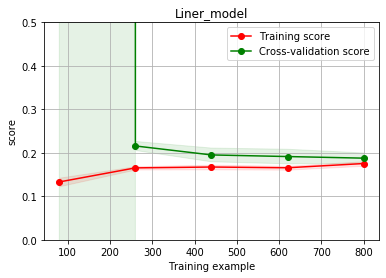

In [45]:
plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1)  

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [47]:
train_y_ln = train_y

In [48]:
models = [LinearRegression(),
          Ridge(),
          Lasso()]

In [49]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished
Lasso is finished


In [50]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.188738,0.189802,0.478972
cv2,0.190103,0.191522,0.476315
cv3,0.190732,0.191847,0.480589
cv4,0.186877,0.188103,0.469473
cv5,0.191253,0.192687,0.477174


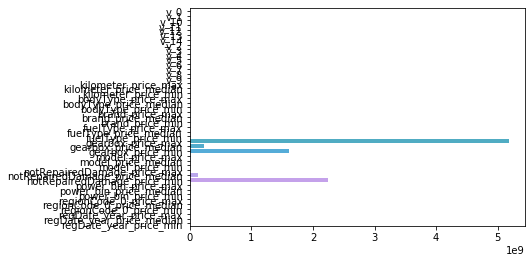

In [79]:
model = LinearRegression().fit(train_X, train_y_ln)
sns.barplot(abs(model.coef_), continuous_feature_names)

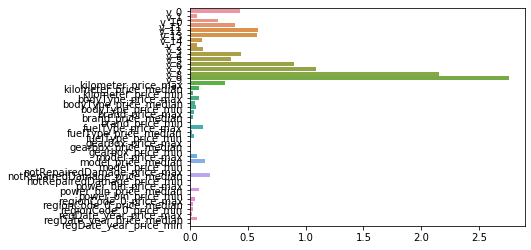

In [80]:
model = Ridge().fit(train_X, train_y_ln)
sns.barplot(abs(model.coef_), continuous_feature_names)

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

In [54]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100), 
          XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
          LGBMRegressor(n_estimators = 100)]

In [58]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
DecisionTreeRegressor is finished
RandomForestRegressor is finished
GradientBoostingRegressor is finished
MLPRegressor is finished
XGBRegressor is finished
LGBMRegressor is finished


In [59]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor,LGBMRegressor
cv1,0.188738,0.188086,0.139013,0.175457,0.186808,0.138239,0.143722
cv2,0.190103,0.186843,0.138613,0.178688,0.194973,0.139259,0.146229
cv3,0.190732,0.189092,0.140513,0.178153,0.189129,0.139165,0.145907
cv4,0.186877,0.186656,0.138176,0.175579,0.181161,0.137077,0.143593
cv5,0.191253,0.187236,0.140035,0.178644,0.190773,0.139791,0.144944


In [60]:
objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']

num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []

### 贪心调参

In [61]:
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
    
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score
    
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score

In [76]:
#sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], y=[0.143 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

### Grid Search 调参

In [63]:
from sklearn.model_selection import GridSearchCV

In [64]:
parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y)

In [65]:
clf.best_params_

{'max_depth': 15, 'num_leaves': 55, 'objective': 'huber'}

In [66]:
model = LGBMRegressor(objective='regression',
                          num_leaves=55,
                          max_depth=15)

In [67]:
np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))

0.13831341952745607

### 贝叶斯调参

In [68]:
from bayes_opt import BayesianOptimization

In [69]:
def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val

In [70]:
def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val

In [71]:
rf_bo = BayesianOptimization(
    rf_cv,
    {
    'num_leaves': (2, 100),
    'max_depth': (2, 100),
    'subsample': (0.1, 1),
    'min_child_samples' : (2, 100)
    }
)

In [72]:
rf_bo.maximize()

|   iter    |  target   | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------
|  1        |  0.8682   |  87.25    |  66.72    |  84.19    |  0.5586   |
|  2        |  0.8434   |  60.49    |  43.07    |  14.45    |  0.8558   |
|  3        |  0.86     |  71.6     |  69.63    |  41.48    |  0.7334   |
|  4        |  0.8654   |  10.23    |  2.936    |  65.33    |  0.8168   |
|  5        |  0.8334   |  25.86    |  28.14    |  9.108    |  0.3843   |
|  6        |  0.8002   |  2.166    |  99.41    |  97.46    |  0.747    |
|  7        |  0.8694   |  99.31    |  3.519    |  98.7     |  0.5388   |
|  8        |  0.7949   |  98.62    |  97.28    |  3.367    |  0.8184   |
|  9        |  0.8695   |  50.37    |  6.424    |  99.47    |  0.8969   |
|  10       |  0.8641   |  79.94    |  2.469    |  56.87    |  0.4728   |
|  11       |  0.8694   |  99.61    |  6.932    |  98.11    |  0.2403   |
|  12       |  0.866    |  50.2     | 

In [73]:
1 - rf_bo.max['target']

0.13027746444666166